In [240]:
from bs4 import BeautifulSoup
import requests 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
## utils 

def get_shemantic_paper_html(where):
    '''
    get page html using filters on citation list
    
    arguments : paper href 
    output : paper html 
    
    
    '''
    
    base_url = 'https://www.semanticscholar.org'
    filter_ = '?citationRankingModelVersion=v0.2.0-0.01&citedPapersSort=relevance&citedPapersLimit=10&citedPapersOffset=0&sort=is-influential'
    URL = base_url+where+filter_
    
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    return soup 
def extract_data(soup):
    ## init 
    data = {}
    cits_list=[]
    refs_list = []
    ## genral info 
    data["title"] = soup.find('h1' , {'data-selenium-selector':'paper-detail-title'}).text
    data['corpus_id'] = soup.find('span' , {'data-selenium-selector':'corpus-id'}).text
    data["additional_data"] = soup.find('span' , {'data-selenium-selector':'year-and-venue'}).text
    ## citations
    score_card = soup.find('span' , {'class':'scorecard-stat__headline'})
    if score_card : 
        
        data["citation_count"] = score_card.text.split(" ")[0]
        
        ## citations type
        citations_count = [div.text for div in  soup.find_all('div' , {'class':'scorecard-citation__metadata-item'})]
        citations_title = [div.text for div in soup.find_all('div' , {'class':'scorecard-citation__title'})]
        if len(citations_title)< len(citations_count) :
            citations_title.insert(0,'Highly Influencial Citations')
            
        data['citations_overview'] = {"cit_titles":citations_title , "cit_count" : citations_count }
        
    else : 
        data["citation_count"] = ''
        data['citations_overview'] ={}
     
    ## paper topics 
    is_topics = soup.find_all('h4',{'class':'card-sidebar__title'})
    if is_topics : 
        data['topics'] = [span.text for span in soup.find_all('span',{'class' :'preview-box__target' })]
    else : data['topics'] = []
    
    ## main citations , refs 
    cards = soup.find_all('div', class_='cl-paper-row citation-list__paper-row')
    citations_cards = cards[:10]
    refs_cards = cards [10:]

    for cit in citations_cards : 
        entry = {}
        entry['title'] = cit.find('div' , class_='cl-paper-title').text
        entry['link'] = cit.find('a')['href']
        
        stats_raw = cit.find('div',class_='cl-paper-controls__stats')#.find_all('div',class_='cl-paper-stat') 
        if stats_raw :
            stats = [div.text for div in stats_raw.find_all('div',class_='cl-paper-stat') ]
            #print(stats)
            entry['stats']=stats
        else : 
            entry['stats']=[]


        cits_list.append(entry)
    for ref in refs_cards : 
        entry = {}
        entry['title'] = ref.find('div' , class_='cl-paper-title').text
        entry['link'] = ref.find('a')['href']
        
        stats_raw = ref.find('div',class_='cl-paper-controls__stats')#.find_all('div',class_='cl-paper-stat') 
        if stats_raw :
            stats = [div.text for div in stats_raw.find_all('div',class_='cl-paper-stat') ]
            #print(stats)
            entry['stats']=stats
        else : 
            entry['stats']=[]


        refs_list.append(entry)
        
            

    data['citations'] = cits_list
    data['references'] = refs_list
    
    ## return data dict 
    return data 

def ravel(list_):return [j for sub in list_ for j in sub]
 
def generate_wcloud(topics_list,max_words=100,stopwords_list =['learning','neural' , 'computer','algorithm','network','Artificial','model']):
    '''
    args : 1d topics list (1 x n)
    output : word cloud image 
    '''
    text = ' '.join(topics_list)
    
    # lower max_font_size, change the maximum number of word and lighten the background:
    stopwords = set(stopwords_list)
    wordcloud = WordCloud(max_font_size=100,stopwords=stopwords, max_words=max_words, background_color="white" ).generate(text)
    print(wordcloud)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

        

In [212]:
## example
paper_where = '/paper/Generative-Adversarial-Nets-Goodfellow-Pouget-Abadie/54e325aee6b2d476bbbb88615ac15e251c6e8214'
soup = get_shemantic_paper_html(paper_where)
data = extract_data(soup)
data

{'title': 'Generative Adversarial Nets',
 'corpus_id': 'Corpus ID: 1033682',
 'additional_data': 'Published in NIPS 2014',
 'citation_count': '19,622',
 'citations_overview': {'cit_titles': ['Highly Influencial Citations',
   'Background Citations',
   ' Methods Citations',
   ' Results Citations'],
  'cit_count': ['3,769', '11,284', '6,519', '176']},
 'topics': ['Generative model',
  'Discriminative model',
  'Backpropagation',
  'Minimax',
  'Markov chain',
  'Multilayer perceptron',
  'Assignment (computer science)',
  'Approximation algorithm',
  'Experiment'],
 'citations': [{'title': 'Generative Adversarial Learning Towards Fast Weakly Supervised Detection',
   'link': '/paper/Generative-Adversarial-Learning-Towards-Fast-Weakly-Shen-Ji/862b9feff7c5f40736d83bbf10abe32c2702c490',
   'stats': ['40', 'Highly Influenced', 'PDF']},
  {'title': 'Unsupervised Representation Learning with Prior-Free and Adversarial Mechanism Embedded Autoencoders',
   'link': '/paper/Unsupervised-Represen

In [209]:
[span.text for span in soup.find_all('span',{'class' :'preview-box__target' })]

['Generative model',
 'Discriminative model',
 'Backpropagation',
 'Minimax',
 'Markov chain',
 'Multilayer perceptron',
 'Assignment (computer science)',
 'Approximation algorithm',
 'Experiment']

[<h4 class="card-sidebar__title">Explore Further: Topics Discussed in This Paper</h4>]

In [215]:
## tense test on scrap function root to citations and ref 
dta = []
paper_where = '/paper/Generative-Adversarial-Nets-Goodfellow-Pouget-Abadie/54e325aee6b2d476bbbb88615ac15e251c6e8214'
soup = get_shemantic_paper_html(paper_where)
data = extract_data(soup)
dta.append(data)
for cit in data['citations'] : 

    print(cit['title'])
    soup = get_shemantic_paper_html(cit['link'])
    data = extract_data(soup)
    dta.append(data)
    print(data)
    print('-----------')
    
    

Generative Adversarial Learning Towards Fast Weakly Supervised Detection
{'title': 'Generative Adversarial Learning Towards Fast Weakly Supervised Detection', 'corpus_id': 'Corpus ID: 51996510', 'additional_data': 'Published 2018', 'citation_count': '40', 'citations_overview': {'cit_titles': ['Highly Influencial Citations', 'Background Citations', ' Methods Citations'], 'cit_count': ['2', '14', '21']}, 'topics': ['Supervised learning', 'Sensor', 'Object detection', 'Structural similarity', 'Programming paradigm', 'Ground truth', 'Procedural generation', 'Feedback', 'Experiment', 'Speedup', 'Minimum bounding box', 'Solid-state drive', 'Real-time clock'], 'citations': [{'title': 'C-MIDN: Coupled Multiple Instance Detection Network With Segmentation Guidance for Weakly Supervised Object Detection', 'link': '/paper/C-MIDN%3A-Coupled-Multiple-Instance-Detection-Network-Yan-Liu/78efaed39a08fb61195701eaf054e3e27b22d03b', 'stats': ['11', 'Highly Influenced', 'PDF']}, {'title': 'Cyclic Guidance

{'title': 'Computer Vision – ECCV 2020: 16th European Conference, Glasgow, UK, August 23–28, 2020, Proceedings, Part XXVIII', 'corpus_id': 'Corpus ID: 226231719', 'additional_data': 'Published 2020', 'citation_count': '', 'citations_overview': {}, 'topics': [], 'citations': [{'title': 'Visual Tracking with Fully Convolutional Networks', 'link': '/paper/Visual-Tracking-with-Fully-Convolutional-Networks-Wang-Ouyang/bf94906f0d7a8ca9da5f6b86e2a476fde1a34dd0', 'stats': ['761', 'PDF']}, {'title': 'A Dual Decomposition Approach to Feature Correspondence', 'link': '/paper/A-Dual-Decomposition-Approach-to-Feature-Torresani-Kolmogorov/977d63d1ad9f03a1e08b900ba76e2f1602f020db', 'stats': ['75', 'Highly Influential']}, {'title': 'Very Deep Convolutional Networks for Large-Scale Image Recognition', 'link': '/paper/Very-Deep-Convolutional-Networks-for-Large-Scale-Simonyan-Zisserman/eb42cf88027de515750f230b23b1a057dc782108', 'stats': ['42,563', 'Highly Influential', 'PDF']}, {'title': 'The Contextual 

{'title': 'Progressive Reconstruction of Visual Structure for Image Inpainting', 'corpus_id': 'Corpus ID: 208003108', 'additional_data': 'Published 2019', 'citation_count': '10', 'citations_overview': {'cit_titles': ['Background Citations', ' Methods Citations', ' Results Citations'], 'cit_count': ['5', '2', '1']}, 'topics': ['Inpainting', 'Discriminator', 'Generalization error', 'Deconvolution', 'Computer vision', 'Convolution', 'Clone tool', 'Image restoration', 'Library (computing)', 'Experiment', 'Circuit restoration'], 'citations': [{'title': 'Recurrent Feature Reasoning for Image Inpainting', 'link': '/paper/Recurrent-Feature-Reasoning-for-Image-Inpainting-Li-Wang/20334266b089240d6d723efdc17511d4929a434a', 'stats': ['4', 'PDF']}, {'title': 'Image Inpainting Guided by Coherence Priors of Semantics and Textures', 'link': '/paper/Image-Inpainting-Guided-by-Coherence-Priors-of-and-Liao-Xiao/26a8e0c99574ade64b9c02a69cb0df1c8c840c50', 'stats': []}, {'title': 'EraseNet: End-to-End Text 

{'title': 'GenEval: A Benchmark Suite for Evaluating Generative Models', 'corpus_id': 'Corpus ID: 53351804', 'additional_data': 'Published 2018', 'citation_count': '', 'citations_overview': {}, 'topics': ['Benchmark (computing)', 'Generative model', 'Robotics', 'Visual inspection', 'Image processing', 'Modality (human–computer interaction)', 'Causal filter', 'Numerous'], 'citations': [{'title': 'A note on the evaluation of generative models', 'link': '/paper/A-note-on-the-evaluation-of-generative-models-Theis-Oord/39e0c341351f8f4a39ac890b96217c7f4bde5369', 'stats': ['645', 'PDF']}, {'title': 'Are GANs Created Equal? A Large-Scale Study', 'link': '/paper/Are-GANs-Created-Equal-A-Large-Scale-Study-Lucic-Kurach/c88e8d85fd5160b0793598bda037f977366acf7a', 'stats': ['467', 'Highly Influential', 'PDF']}, {'title': 'Improved Techniques for Training GANs', 'link': '/paper/Improved-Techniques-for-Training-GANs-Salimans-Goodfellow/571b0750085ae3d939525e62af510ee2cee9d5ea', 'stats': ['3,866', 'PDF

In [192]:
!pip install flask-restful

     |████████████████████████████████| 44 kB 315 kB/s eta 0:00:01


In [216]:
print(len(dta))
top_list = [data['topics'] for data in dta]

11


In [217]:
top_list 

[['Generative model',
  'Discriminative model',
  'Backpropagation',
  'Minimax',
  'Markov chain',
  'Multilayer perceptron',
  'Assignment (computer science)',
  'Approximation algorithm',
  'Experiment'],
 ['Supervised learning',
  'Sensor',
  'Object detection',
  'Structural similarity',
  'Programming paradigm',
  'Ground truth',
  'Procedural generation',
  'Feedback',
  'Experiment',
  'Speedup',
  'Minimum bounding box',
  'Solid-state drive',
  'Real-time clock'],
 ['Supervised learning',
  'Feature learning',
  'Unsupervised learning',
  'Embedded system',
  'Artificial neural network',
  'Machine learning',
  'High- and low-level',
  'Pixel',
  'Adversary (cryptography)',
  "Eisenstein's criterion"],
 [],
 [],
 ['Randomized algorithm',
  'Nonlinear system',
  'Deep learning',
  'Black box',
  'Plasma cleaning',
  'Artificial neural network',
  'White-box testing'],
 ['Inpainting',
  'Discriminator',
  'Generalization error',
  'Deconvolution',
  'Computer vision',
  'Convol

In [225]:
!pip install wordcloud

     |████████████████████████████████| 220 kB 488 kB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=160313 sha256=904edf1a7d3245fd2553293d275397f6654adc8ac19be5e4179075948f84d7d0
  Stored in directory: /Users/mac/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built wordcloud
Note: you may need to restart the kernel to use updated packages.


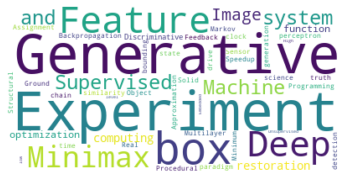

In [246]:
topics = ravel(top_list)
generate_wcloud(topics,max_words=50)


In [204]:
from flask import Flask
from flask_restful import Resource, Api, reqparse
import pandas as pd
import ast
app = Flask(__name__)
api = Api(app)


class Parser(Resource):
    def get(self):
        parser = reqparse.RequestParser()  # initialize
        
        parser.add_argument('paper_id', required=True)  # add args

        
        args = parser.parse_args()
        paper_where =args['paper_id']
        soup = get_shemantic_paper_html(paper_where)
        data = extract_data(soup)
        #print(paper_where)
        
         
        return data, 200  # return data and 200 OK code
    

    
api.add_resource(Parser, '/parse') 


if __name__ == '__main__':
    app.run()  # run our Flask app

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Dec/2020 17:08:58] "GET /parse?paper_id=/paper/Large-Scale-GAN-Training-for-High-Fidelity-Natural-Brock-Donahue/22aab110058ebbd198edb1f1e7b4f69fb13c0613 HTTP/1.1" 200 -
127.0.0.1 - - [25/Dec/2020 17:09:55] "GET /parse?paper_id=/paper/Large-Scale-GAN-Training-for-High-Fidelity-Natural-Brock-Donahue/22aab110058ebbd198edb1f1e7b4f69fb13c0613 HTTP/1.1" 200 -
127.0.0.1 - - [25/Dec/2020 17:10:22] "GET /parse?paper_id=/paper/High-Fidelity-Image-Generation-With-Fewer-Labels-Lucic-Tschannen/f34f14faa6f6144adb626fa8dee1286f0b734772 HTTP/1.1" 200 -


In [203]:
## test api in browser
url = 'http://127.0.0.1:5000/parse?paper_id=/paper/Generative-Adversarial-Nets-Goodfellow-Pouget-Abadie/54e325aee6b2d476bbbb88615ac15e251c6e8214'




ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /parse?paper_id=/paper/Generative-Adversarial-Nets-Goodfellow-Pouget-Abadie/54e325aee6b2d476bbbb88615ac15e251c6e8214 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb3531a6310>: Failed to establish a new connection: [Errno 61] Connection refused'))